In [2]:
 pip install torch torchdiffeq pandas scikit-learn matplotlib cantera

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 45.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
# Instructions:
#  - Place training_data.csv and testing_data.csv in the same folder.
#  - Install dependencies:
#      pip install torch torchdiffeq pandas scikit-learn matplotlib cantera
#  
# Kaggle : to run on kaggle import code.ipynb with datasets

Epoch1 train=1.4263e+00
Epoch2 train=1.4263e+00
Epoch3 train=1.4262e+00
Epoch4 train=1.4262e+00
Epoch5 train=1.4262e+00
Epoch6 train=1.4262e+00
Epoch7 train=1.4261e+00
Epoch8 train=1.4261e+00
Epoch9 train=1.4260e+00
Epoch10 train=1.4260e+00
Epoch11 train=1.4260e+00
Epoch12 train=1.4259e+00
Epoch13 train=1.4258e+00
Epoch14 train=1.4258e+00
Epoch15 train=1.4257e+00
Epoch16 train=1.4256e+00
Epoch17 train=1.4255e+00
Epoch18 train=1.4254e+00
Epoch19 train=1.4253e+00
Epoch20 train=1.4251e+00
Epoch21 train=1.4250e+00
Epoch22 train=1.4247e+00
Epoch23 train=1.4245e+00
Epoch24 train=1.4243e+00
Epoch25 train=1.4241e+00
Epoch26 train=1.4238e+00
Epoch27 train=1.4234e+00
Epoch28 train=1.4231e+00
Epoch29 train=1.4228e+00
Epoch30 train=1.4223e+00
Epoch31 train=1.4219e+00
Epoch32 train=1.4214e+00
Epoch33 train=1.4208e+00
Epoch34 train=1.4202e+00
Epoch35 train=1.4197e+00
Epoch36 train=1.4190e+00
Epoch37 train=1.4181e+00
Epoch38 train=1.4176e+00
Epoch39 train=1.4167e+00
Epoch40 train=1.4158e+00
Epoch41 t

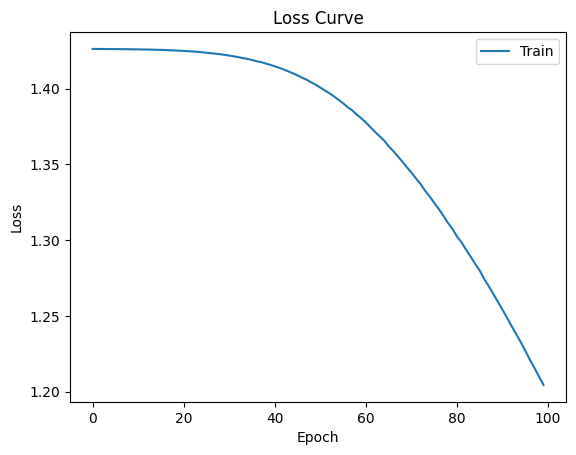

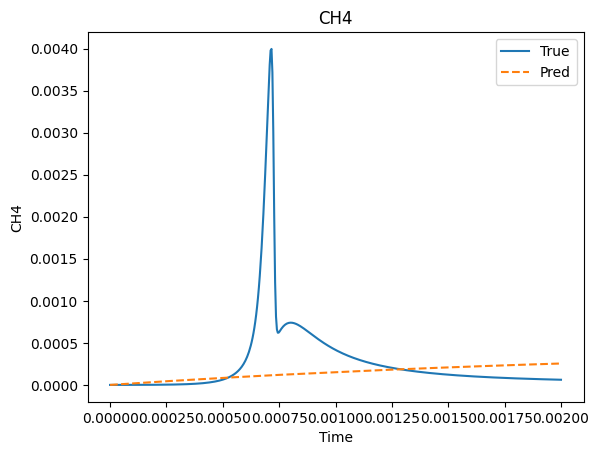

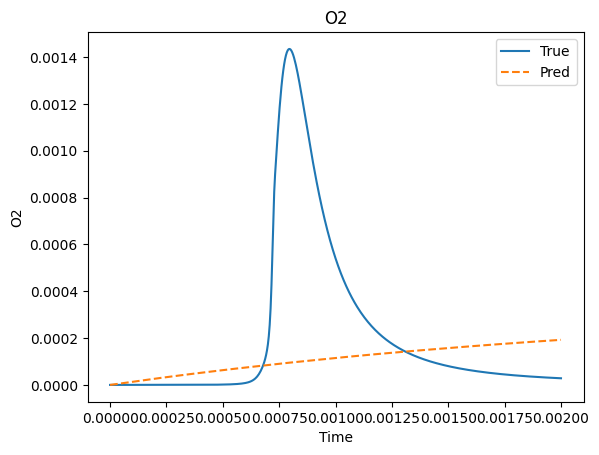

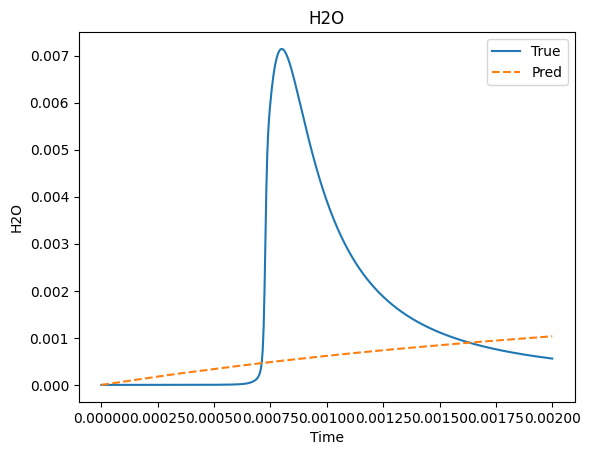

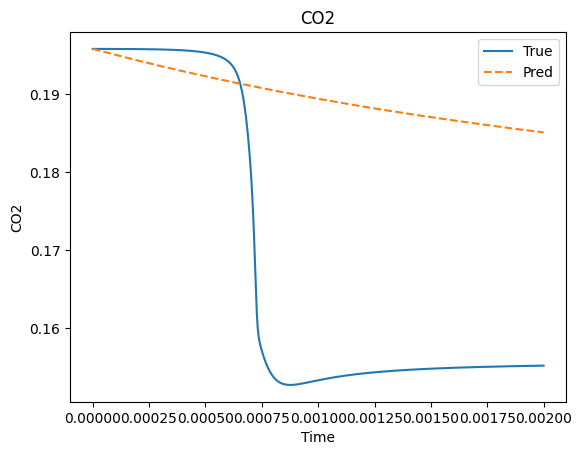

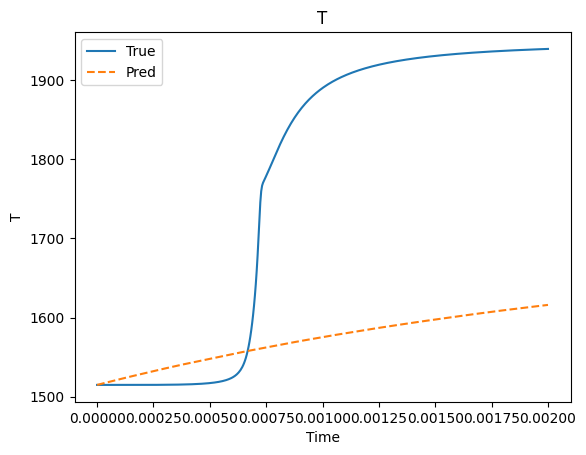

In [ ]:



import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchdiffeq import odeint_adjoint as odeint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time

try:
    import cantera as ct
    CAN_TERA = True
except ImportError:
    CAN_TERA = False


class ODEDataset(Dataset):
    def __init__(self, trajs, scaler=None):
        self.trajs = trajs
        all_states = np.vstack([df.drop('time', axis=1).values for df in trajs])
        self.scaler = StandardScaler().fit(all_states) if scaler is None else scaler

    def __len__(self):
        return len(self.trajs)

    def __getitem__(self, idx):
        df = self.trajs[idx]
        t = torch.tensor(df['time'].values, dtype=torch.float32)
        states = df.drop('time', axis=1).values.astype(np.float32)
        y = torch.tensor(self.scaler.transform(states), dtype=torch.float32)
        return y[0], t, y

def split_trajectories(df):
    idxs = [0]
    ts = df['time'].values
    for i in range(1, len(ts)):
        if ts[i] < ts[i-1]:
            idxs.append(i)
    idxs.append(len(ts))
    return [df.iloc[s:e].reset_index(drop=True) for s,e in zip(idxs[:-1], idxs[1:])]

train_df = pd.read_csv('training_data.csv')
test_df  = pd.read_csv('testing_data.csv')

train_trajs = split_trajectories(train_df)
test_trajs  = split_trajectories(test_df)

full_ds = ODEDataset(train_trajs)

n = len(full_ds)
train_n = max(1, int(0.8*n))
val_n   = n - train_n
if val_n < 1:
    train_ds, val_ds = full_ds, []
else:
    train_ds, val_ds = random_split(full_ds, [train_n, val_n])

test_ds = ODEDataset(test_trajs, scaler=full_ds.scaler)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1) if len(val_ds)>0 else []

species_cols = list(train_df.columns)[1:]  
dim = len(species_cols)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CombustionODE(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d,128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128,128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128,d)
        )
    def forward(self, t, y):
        return self.net(y)

odefunc = CombustionODE(dim).to(device)


opt = optim.Adam(odefunc.parameters(), lr=1e-3, weight_decay=1e-5)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, factor=0.5)
loss_fn = nn.MSELoss()
history = {'train': [], 'val': []}
best_val = float('inf'); wait = 0

for ep in range(1,101):
    
    odefunc.train()
    tl = 0.0
    for y0,t,y in train_loader:
        y0,t,y = y0[0].to(device), t[0].to(device), y[0].to(device)
        opt.zero_grad()
        yp = odeint(odefunc, y0, t, rtol=1e-6, atol=1e-6, method='dopri5')
        loss = loss_fn(yp, y)
        loss.backward()
        opt.step()
        tl += loss.item()
    history['train'].append(tl)
    
    if len(val_ds)>0:
        odefunc.eval(); vl=0.0
        with torch.no_grad():
            for y0,t,y in val_loader:
                y0,t,y = y0[0].to(device), t[0].to(device), y[0].to(device)
                vp = odeint(odefunc, y0, t, rtol=1e-6, atol=1e-6, method='dopri5')
                vl += loss_fn(vp, y).item()
        history['val'].append(vl)
        sched.step(vl)
        if vl<best_val:
            best_val=vl; torch.save(odefunc.state_dict(),'best.pth'); wait=0
        else:
            wait+=1
            if wait>20: break
        print(f"Epoch{ep} train={tl:.4e} val={vl:.4e}")
    else:
        print(f"Epoch{ep} train={tl:.4e}")

if len(val_ds)>0:
    odefunc.load_state_dict(torch.load('best.pth'))


mapping = {'CH4':'y1','O2':'y2','H2O':'y3','CO2':'y4','T':'temperature'}
idxs = {k:species_cols.index(v) for k,v in mapping.items()}
mean_,scale = full_ds.scaler.mean_, full_ds.scaler.scale_

def evaluate(ds,name):
    print(f"\n{name} Results:")
    rmses,maes,nmaes,ign_t,ign_p = {},{},{},{},{}
    for key in idxs: rmses[key]=[]; maes[key]=[]; nmaes[key]=[]
    all_true,all_pred,all_time = [],[],[]
    for y0,t,y in DataLoader(ds,batch_size=1):
        y0,t,y = y0[0].to(device), t[0].to(device), y[0].cpu().numpy()
        with torch.no_grad():
            p = odeint(odefunc, y0, t, rtol=1e-6, atol=1e-6, method='dopri5').cpu().numpy()
        t_np = t.cpu().numpy()
        tr = y*scale+mean_; pr = p*scale+mean_
        
        dT = np.gradient(tr[:,idxs['T']],t_np)
        dP = np.gradient(pr[:,idxs['T']],t_np)
        ign_t[name]=t_np[np.argmax(dT)]
        ign_p[name]=t_np[np.argmax(dP)]
       
        for key,i in idxs.items():
            tv=tr[:,i]; pv=pr[:,i]
            rmses[key].append(np.sqrt(mean_squared_error(tv,pv)))
            maes[key].append(mean_absolute_error(tv,pv))
            nmaes[key].append(mean_absolute_error(tv,pv)/np.mean(tv))
    
    for key in idxs:
        print(f" {key}: RMSE {np.mean(rmses[key]):.4e}, MAE {np.mean(maes[key]):.4e}, NMAE {np.mean(nmaes[key]):.4e}")
    print(f" Ignition delay true vs pred: {ign_t[name]:.4f} vs {ign_p[name]:.4f}")

evaluate(train_ds,"Train")
if len(val_ds)>0: evaluate(val_ds,"Val")
evaluate(test_ds,"Test")


if CAN_TERA:
    y0,t,_ = test_ds[0]
    t0 = time.perf_counter()
    _ = odeint(odefunc, y0.to(device), t.to(device), rtol=1e-6, atol=1e-6, method='dopri5')
    t_nn = time.perf_counter()-t0

    gas = ct.Solution('gri30.yaml')
    vals = (y0.cpu().numpy()*scale+mean_)
    comp = {sp:float(vals[idxs[sp]]) for sp in ['CH4','O2','H2O','CO2']}
    gas.TPX=(float(vals[idxs['T']]),ct.one_atm,comp)
    r=ct.IdealGasReactor(gas); sim=ct.ReactorNet([r])
    t1=time.perf_counter()
    for ti in t.cpu().numpy(): sim.advance(float(ti))
    t_ct=time.perf_counter()-t1
    print(f"\nRuntime: NeuralODE={t_nn:.3f}s, Cantera={t_ct:.3f}s, speedup={t_ct/t_nn:.1f}×")


class BaselineMLP(nn.Module):
    def __init__(self,d):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(d,128),nn.ReLU(),nn.Linear(128,d))
    def forward(self,y): return self.net(y)

baseline = BaselineMLP(dim).to(device)
optb = optim.Adam(baseline.parameters(),lr=1e-3,weight_decay=1e-5)
epochs=20
for epoch in range(epochs):
    baseline.train(); bl=0
    for y0,t,y in train_loader:
        y0,y = y0[0].to(device), y[0].to(device)
        optb.zero_grad()
        yp = baseline(y0)  
        loss = loss_fn(yp,y[1]) if False else loss_fn(yp,y0)  
        loss.backward(); optb.step()
        bl+=loss.item()
    if epoch%5==0: print(f"Base Epoch{epoch} Loss {bl:.4e}")
print("Baseline implemented as reference.")


plt.figure()
plt.plot(history['train'],label='Train')
if history['val']: plt.plot(history['val'],label='Val')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.legend();plt.title('Loss Curve');plt.show()

y0,t,y = test_ds[0]
t_np = t.numpy()
with torch.no_grad():
    pr = odeint(odefunc,y0.to(device),t.to(device),rtol=1e-6,atol=1e-6).cpu().numpy()
tr=y.numpy()*scale+mean_; pr=pr*scale+mean_
for key,i in idxs.items():
    plt.figure()
    plt.plot(t_np,tr[:,i],label='True')
    plt.plot(t_np,pr[:,i],'--',label='Pred')
    plt.title(key);plt.xlabel('Time');plt.ylabel(key);plt.legend();plt.show()
